In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

from tensorflow import keras
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing() # loading the California Housing dataset

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42) # test and train
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42) # training and validation

# Using the StandardScaler to scale the dataset

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [4]:
X_train.shape, X_valid.shape, X_test.shape

((11610, 8), (3870, 8), (5160, 8))

In [5]:
np.random.seed(42) # generating random see
tf.random.set_seed(42) # setting random seed

In [6]:
# Creating the model using the Sequential API

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3)) # compiling the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) # fit the model
mse_test = model.evaluate(X_test, y_test) # evaluating
X_new = X_test[:3]
y_pred = model.predict(X_new) # predicting

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 141us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 1s 92us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 1s 84us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5004 - val

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


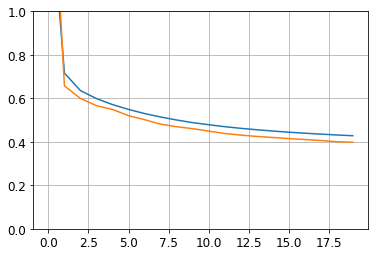

In [8]:
import pandas as pd
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1) # setting y-axis limit
plt.show()

In [9]:
y_pred # printing the predictions

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

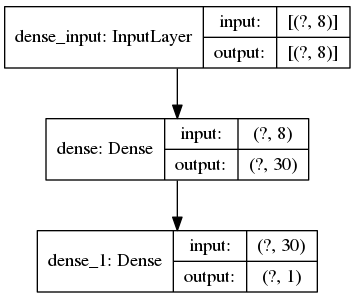

In [10]:
keras.utils.plot_model(model, "my_regression_mlp.png", show_shapes=True)

### Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see paper) connects all or part of the inputs directly to the output layer.

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
X_train.shape[1:]

(8,)

In [13]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2]) # concatenate inputs
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [14]:
model.summary() # generating model summary

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 30)           930         dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                

In [15]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3)) # compile model
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid)) # fit model
mse_test = model.evaluate(X_test, y_test) # evaluate model

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 127us/sample - loss: 1.2390 - val_loss: 0.6566
Epoch 2/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.6312 - val_loss: 0.6734
Epoch 3/20
11610/11610 [==============================] - 1s 101us/sample - loss: 0.5886 - val_loss: 0.5574
Epoch 4/20
11610/11610 [==============================] - 1s 95us/sample - loss: 0.5595 - val_loss: 0.5235
Epoch 5/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.5361 - val_loss: 0.5011
Epoch 6/20
11610/11610 [==============================] - 1s 93us/sample - loss: 0.5178 - val_loss: 0.5065
Epoch 7/20
11610/11610 [==============================] - 1s 90us/sample - loss: 0.5016 - val_loss: 0.4699
Epoch 8/20
11610/11610 [==============================] - 1s 90us/sample - loss: 0.4888 - val_loss: 0.4745
Epoch 9/20
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4772 - val

In [16]:
y_pred = model.predict(X_test) # predict using the model

In [17]:
y_pred

array([[0.47253639],
       [1.8545784 ],
       [3.341889  ],
       ...,
       [1.3345504 ],
       [2.1782694 ],
       [3.8309045 ]], dtype=float32)

### Different input paths

In [18]:
# creating the model using different number of layers

input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2]) # concatenate inputs
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [19]:
X_train.shape

(11610, 8)

In [20]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3)) # compile the model

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 128us/sample - loss: 1.7519 - val_loss: 1.0401
Epoch 2/20
11610/11610 [==============================] - 1s 92us/sample - loss: 0.7637 - val_loss: 0.6781
Epoch 3/20
11610/11610 [==============================] - 1s 91us/sample - loss: 0.6601 - val_loss: 0.5982
Epoch 4/20
11610/11610 [==============================] - 1s 88us/sample - loss: 0.6045 - val_loss: 0.5664
Epoch 5/20
11610/11610 [==============================] - 1s 69us/sample - loss: 0.5667 - val_loss: 0.5574
Epoch 6/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5400 - val_loss: 0.5338
Epoch 7/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5184 - val_loss: 0.5104
Epoch 8/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5025 - val_loss: 0.4768
Epoch 9/20
11610/11610 [==============================] - 1s 68us/sample - loss: 0.4899 - val_

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
____________________________________________________________________________________________

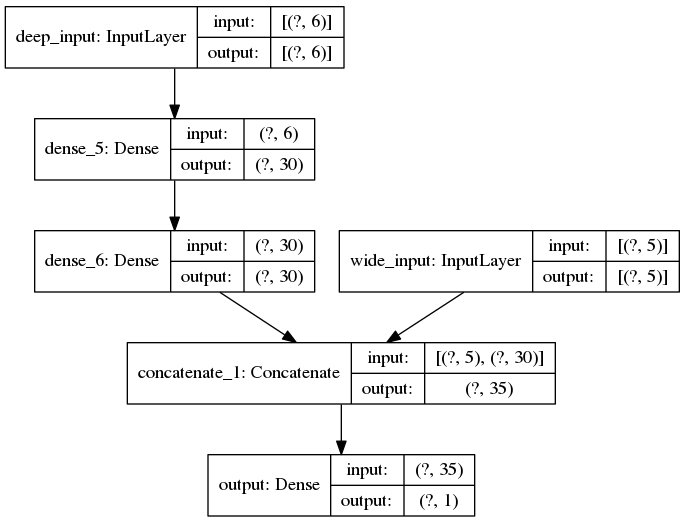

In [22]:
keras.utils.plot_model(model, "wide_and_narrow_2_inputs.png", show_shapes=True)

### Adding 2 outputs

In [23]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2]) # concatenate the inputs
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2) # aux output for regularization
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [24]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3)) # compile the model

In [25]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])) # fit the model

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 124us/sample - loss: 2.7499 - main_output_loss: 2.2697 - aux_output_loss: 7.0625 - val_loss: 2.1061 - val_main_output_loss: 1.6838 - val_aux_output_loss: 5.9009
Epoch 2/20
11610/11610 [==============================] - 1s 75us/sample - loss: 1.1736 - main_output_loss: 0.8291 - aux_output_loss: 4.2754 - val_loss: 0.9527 - val_main_output_loss: 0.7201 - val_aux_output_loss: 3.0443
Epoch 3/20
11610/11610 [==============================] - 1s 76us/sample - loss: 0.8599 - main_output_loss: 0.6745 - aux_output_loss: 2.5279 - val_loss: 0.7658 - val_main_output_loss: 0.6180 - val_aux_output_loss: 2.0947
Epoch 4/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.7320 - main_output_loss: 0.6156 - aux_output_loss: 1.7781 - val_loss: 0.6951 - val_main_output_loss: 0.5757 - val_aux_output_loss: 1.7679
Epoch 5/20
11610/11610 [==============================] - 1s 78us/

In [26]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B]) # predicting using aux layer

5160/5160 [==============================] - 0s 43us/sample - loss: 0.4620 - main_output_loss: 0.4210 - aux_output_loss: 0.8343


In [27]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 30)           930         dense_7[0][0]                    
____________________________________________________________________________________________

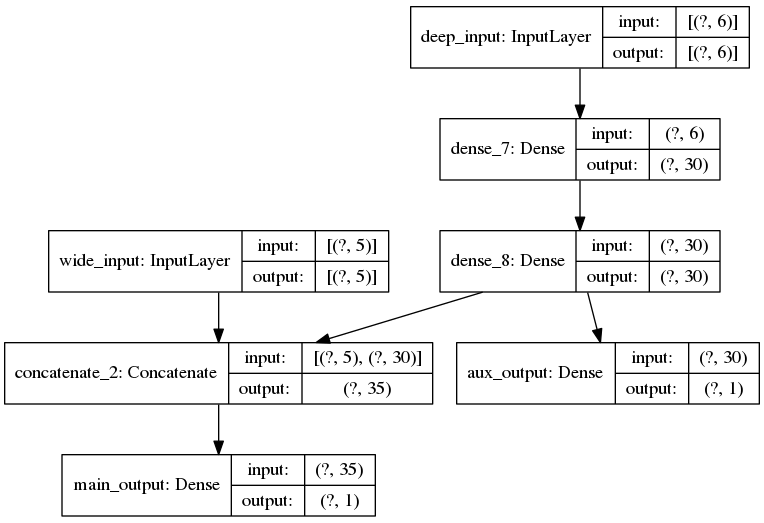

In [28]:
keras.utils.plot_model(model, "wide_and_narrow_2_inputs_2_outputs.png", show_shapes=True)

### SubClassing API

In [29]:
# Creating the WideAndDeepModel using subclassing

class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [30]:
# Compiling, evaluating, and predicting the model

model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 159us/sample - loss: 2.6273 - output_1_loss: 2.3216 - output_2_loss: 5.3702 - val_loss: 10.1114 - val_output_1_loss: 10.3759 - val_output_2_loss: 7.6836
Epoch 2/10
11610/11610 [==============================] - 1s 104us/sample - loss: 1.1419 - output_1_loss: 0.8475 - output_2_loss: 3.7931 - val_loss: 2.0641 - val_output_1_loss: 1.2161 - val_output_2_loss: 9.6884
Epoch 3/10
11610/11610 [==============================] - 1s 99us/sample - loss: 0.8468 - output_1_loss: 0.6484 - output_2_loss: 2.6311 - val_loss: 1.6251 - val_output_1_loss: 0.5848 - val_output_2_loss: 10.9816
Epoch 4/10
11610/11610 [==============================] - 1s 95us/sample - loss: 0.7416 - output_1_loss: 0.5966 - output_2_loss: 2.0443 - val_loss: 1.6214 - val_output_1_loss: 0.5835 - val_output_2_loss: 10.9560
Epoch 5/10
11610/11610 [==============================] - 1s 96us/sample - loss: 0.6837 - output_1_lo

In [31]:
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  210       
_________________________________________________________________
dense_10 (Dense)             multiple                  930       
_________________________________________________________________
dense_11 (Dense)             multiple                  36        
_________________________________________________________________
dense_12 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


### Saving and Restoring

In [32]:
# creating a model to demonstrate saving and restoring

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])  

In [33]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3)) # compile the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid)) # fit the model
mse_test = model.evaluate(X_test, y_test) # evalutate the model

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 115us/sample - loss: 2.0284 - val_loss: 5.5453
Epoch 2/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.8483 - val_loss: 0.7947
Epoch 3/10
11610/11610 [==============================] - 1s 65us/sample - loss: 0.7207 - val_loss: 0.6519
Epoch 4/10
11610/11610 [==============================] - 1s 67us/sample - loss: 0.6700 - val_loss: 0.6097
Epoch 5/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.6324 - val_loss: 0.5889
Epoch 6/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.6011 - val_loss: 0.5494
Epoch 7/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.5716 - val_loss: 0.5206
Epoch 8/10
11610/11610 [==============================] - 1s 68us/sample - loss: 0.5465 - val_loss: 0.5263
Epoch 9/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5233 - val_

In [34]:
model.save("my_keras_model.h5") # Saving the model

In [35]:
!strings my_keras_model.h5

TREE
HEAP
model_weights
optimizer_weights
keras_version
backend
model_config
training_config
TREE
HEAP
dense_13
dense_14
dense_15
layer_names
dense_13dense_14dense_15
GCOL
2.2.4-tf
tensorflow
{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_13", "trainable": true, "batch_input_shape": [null, 8], "dtype": "float32", "units": 30, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_14", "trainable": true, "dtype": "float32", "units": 30, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "con

In [36]:
model1 = keras.models.load_model("my_keras_model.h5") # Loading the model

In [37]:
model1.predict(X_new)

array([[0.7171394],
       [1.419239 ],
       [2.9505818]], dtype=float32)

In [38]:
model.save_weights("my_keras_weights.ckpt") # saving the weights

In [39]:
model.load_weights("my_keras_weights.ckpt") # loading the saved weights

### Using Callbacks

In [40]:
# Defining the model to demostrate callbacks

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])  

In [41]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) # saving the best model checkpoint
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb]) # using the callback
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 101us/sample - loss: 2.2523 - val_loss: 3.1653
Epoch 2/30
11610/11610 [==============================] - 1s 79us/sample - loss: 0.8063 - val_loss: 0.7010
Epoch 3/30
11610/11610 [==============================] - 1s 74us/sample - loss: 0.6213 - val_loss: 0.5690
Epoch 4/30
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5718 - val_loss: 0.5410
Epoch 5/30
11610/11610 [==============================] - 1s 71us/sample - loss: 0.5366 - val_loss: 0.5100
Epoch 6/30
11610/11610 [==============================] - 1s 70us/sample - loss: 0.5080 - val_loss: 0.4764
Epoch 7/30
11610/11610 [==============================] - 1s 93us/sample - loss: 0.4842 - val_loss: 0.4547
Epoch 8/30
11610/11610 [==============================] - 1s 113us/sample - loss: 0.4658 - val_loss: 0.4334
Epoch 9/30
11610/11610 [==============================] - 1s 101us/sample - loss: 0.4515 - va

In [42]:
!ls my_keras_model.h5

my_keras_model.h5


In [43]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 91us/sample - loss: 0.3821 - val_loss: 0.3912
Epoch 2/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3805 - val_loss: 0.3858
Epoch 3/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.3789 - val_loss: 0.3854
Epoch 4/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3777 - val_loss: 0.3919
Epoch 5/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3763 - val_loss: 0.3853
Epoch 6/100
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3750 - val_loss: 0.3962
Epoch 7/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3738 - val_loss: 0.3756
Epoch 8/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.3727 - val_loss: 0.3634
Epoch 9/100
11610/11610 [==============================] - 1s 72us/sample - loss: 0.371

In [44]:
mse_test = model.evaluate(X_valid, y_valid)

3870/3870 [==============================] - 0s 35us/sample - loss: 0.3519


In [45]:
# Creating custom callback

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n SG :: val/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [46]:
val_train_ratio_cb = PrintValTrainRatioCallback() # calling the custom callback
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb]) # fitting the model using the custom callback

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11200/11610 [===========================>..] - ETA: 0s - loss: 0.3638
 SG :: val/train: 1.01
11610/11610 [==============================] - 1s 69us/sample - loss: 0.3631 - val_loss: 0.3662
Epoch 2/5
11488/11610 [============================>.] - ETA: 0s - loss: 0.3610
 SG :: val/train: 0.99
11610/11610 [==============================] - 1s 69us/sample - loss: 0.3625 - val_loss: 0.3572
Epoch 3/5
10688/11610 [==========================>...] - ETA: 0s - loss: 0.3624
 SG :: val/train: 1.00
11610/11610 [==============================] - 1s 67us/sample - loss: 0.3615 - val_loss: 0.3598
Epoch 4/5
11008/11610 [===========================>..] - ETA: 0s - loss: 0.3607
 SG :: val/train: 1.01
11610/11610 [==============================] - 1s 70us/sample - loss: 0.3612 - val_loss: 0.3642
Epoch 5/5
11488/11610 [============================>.] - ETA: 0s - loss: 0.3590
 SG :: val/train: 0.99
11610/11610 [==============================] - 1s 68

### TensorBoard Visualisation

In [47]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [48]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_09_10-16_42_19'

In [49]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [51]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb, val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11584/11610 [============================>.] - ETA: 0s - loss: 1.8448
 SG :: val/train: 2.83
11610/11610 [==============================] - 1s 115us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/30
11392/11610 [============================>.] - ETA: 0s - loss: 0.6866
 SG :: val/train: 1.12
11610/11610 [==============================] - 1s 81us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/30
10816/11610 [==========================>...] - ETA: 0s - loss: 0.6011
 SG :: val/train: 0.91
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/30
11456/11610 [============================>.] - ETA: 0s - loss: 0.5569
 SG :: val/train: 0.98
11610/11610 [==============================] - 1s 78us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/30
11360/11610 [============================>.] - ETA: 0s - loss: 0.5272
 SG :: val/train: 1.05
11610/11610 [==============================] -

To start the TensorBoard server, open a terminal and type below command in terminal

/usr/local/anaconda/envs/tensorflow2/bin/tensorboard --logdir=./my_logs --port=4049 --bind_all
If you are getting error that port is already in use, then please use any other port in the range of 4040 to 4140. Once TensorBoard server is started then please go to below url to access it

http://your_web_console:your_port_number

Replace your_web_console with your CloudxLab web console address. Say your console is on f.cloudxlab.com then your_web_console will be f.cloudxlab.com. your_port_number will be the port on which your TensorBoard server is running. Below is the fully qualified url for accessing your TensorBoard server

http://f.cloudxlab.com:4049

Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

In [52]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2020_09_10-16_42_47'

In [53]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
# running another model to compare

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(3, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.5))

In [55]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2) # calling the Tensorboard using the second model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 104us/sample - loss: 1.6776 - val_loss: 1.3386
Epoch 2/30
11610/11610 [==============================] - 1s 73us/sample - loss: 1.3823 - val_loss: 1.3153
Epoch 3/30
11610/11610 [==============================] - 1s 76us/sample - loss: 1.3840 - val_loss: 1.3311
Epoch 4/30
11610/11610 [==============================] - 1s 77us/sample - loss: 1.3786 - val_loss: 1.4583
Epoch 5/30
11610/11610 [==============================] - 1s 74us/sample - loss: 1.3793 - val_loss: 1.4866
Epoch 6/30
11610/11610 [==============================] - 1s 74us/sample - loss: 1.3845 - val_loss: 1.3411
Epoch 7/30
11610/11610 [==============================] - 1s 74us/sample - loss: 1.3735 - val_loss: 1.4338
Epoch 8/30
11610/11610 [==============================] - 1s 76us/sample - loss: 1.3772 - val_loss: 1.3247
Epoch 9/30
11610/11610 [==============================] - 1s 78us/sample - loss: 1.3815 - val_

In [56]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.

